Now, let's try a MLP (Multi-layer Perceptron) version based on maximizing the log-likelihood of the training data by adding a weight decay penalty (similar to ridge regression). Let's associate a feature vector with each word, allowing similar words to be placed together near the feature space, generalizing knowledge.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
%matplotlib inline

words = pd.read_table('names.txt', header=None, names=['name'])
words[:8]

,name
0,emma
1,olivia
2,ava
3,isabella
4,sophia
5,charlotte
6,mia
7,amelia


In [2]:
chars = sorted(list(set(''.join(words['name']))))
char_to_idx = {c: i + 1 for i, c in enumerate(chars)}
char_to_idx['.'] = 0
idx_to_char = {i: c for c, i in char_to_idx.items()}

In [3]:
# build dataset

bsize = 3
X, Y = [], []
for w in words['name'][:5]:
    print(w)
    # use 3 previous characters to predict the next one (0 is the idx of ',', our starting token)
    context = [0] * bsize

    for ch in w + '.':
        idx = char_to_idx[ch]
        X.append(context)
        Y.append(idx)

        # cropping and adding the next letter
        context = context[1:] + [idx]

X, Y = torch.tensor(X), torch.tensor(Y)

emma
... -> e
..e -> m
.em -> m
emm -> a
mma -> .
olivia
... -> o
..o -> l
.ol -> i
oli -> v
liv -> i
ivi -> a
via -> .
ava
... -> a
..a -> v
.av -> a
ava -> .
isabella
... -> i
..i -> s
.is -> a
isa -> b
sab -> e
abe -> l
bel -> l
ell -> a
lla -> .
sophia
... -> s
..s -> o
.so -> p
sop -> h
oph -> i
phi -> a
hia -> .


In [4]:
# X is the training set, Y are the training labels
# now, let's make C (taken from (https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf, page 1142)

C = torch.randn((27, 2))

F.one_hot(torch.tensor(5), num_classes = 27).float() @ C

emb = C[X]

W1 = torch.randn((6, 100))
b1 = torch.randn(100)

# now, we want to transform the embedding into a 32 x 6 tensor so we can make the actual dot product multiplication work

new_emb = torch.cat(torch.unbind(emb, dim = 1), dim = 1)

# the above is a way to do it, but there is another way of doing this
a = torch.arange(18)

#  can we adjust a tensor by using .view(), which is significantly more efficent than our previous approaches
h = emb.view(-1, 6) @ W1 + b1
h = torch.tanh(h)

# second layer
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

logits = h @ W2 + b2
probabilities = logits.softmax(dim = 1)

loss = -probabilities[torch.arange(32), Y].log().mean()
loss

tensor(13.6356)

In [5]:
g = torch.Generator().manual_seed(214783647)
C = torch.randn((27, 2), generator = g)
W1 = torch.randn((6, 100), generator = g)
b1 = torch.randn(100, generator = g)
W2 = torch.randn((100, 27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]

# total number of parameters

sum(p.nelement() for p in parameters)

3481

In [6]:
emb = C[X]
h = emb.view(-1, 6) @ W1 + b1
logits = torch.tanh(h) @ W2 + b2
# probabilities = logits.softmax(dim = 1)
# loss = -probabilities[torch.arange(32), Y].log().mean()
# loss

# F.cross_entropy does the same thing as the above
# It is faster and more stable (because it uses less memory because no initialization of variables is needed)
# It also allows a much easier backward pass for the gradient
# It is also inherently much more well behaved as well

loss = F.cross_entropy(logits, Y)

In [7]:
for p in parameters:
    p.requires_grad = True

for n in range(1000):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1) + b1 # first layer, results in a (32, 100) tensor
    logits = (h @ W2) + b2 # second layer, results in a (32, 27) tensor

    loss = F.cross_entropy(logits, Y)
    print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    for p in parameters:
        p.data -= 0.1 * p.grad

loss

28.968210220336914
20.850440979003906
16.83432960510254
13.71056079864502
11.952598571777344
9.983345985412598
8.796515464782715
7.226052761077881
6.280444145202637
5.598768711090088
5.235840320587158
4.345327854156494
4.041016101837158
3.193441390991211
2.8981435298919678
2.4902143478393555
2.5072643756866455
1.9073258638381958
1.8327525854110718
1.6618878841400146
1.7488465309143066
1.300340175628662
1.135163426399231
1.0623431205749512
1.1632041931152344
0.7910352945327759
0.6848941445350647
0.6237649321556091
0.6185415387153625
0.5203669667243958
0.5080596804618835
0.45047327876091003
0.4414741098880768
0.4090205729007721
0.4043352007865906
0.3828713297843933
0.37957078218460083
0.36476728320121765
0.36197608709335327
0.35138964653015137
0.3488447666168213
0.3410436511039734
0.33867305517196655
0.3327783942222595
0.3305663466453552
0.32601380348205566
0.32395896315574646
0.3203718662261963
0.3184748888015747
0.31559473276138306
0.31385356187820435
0.31149864196777344
0.309908509254

tensor(0.2546, grad_fn=<NllLossBackward0>)

In [8]:
logits.max(1)

torch.return_types.max(
values=tensor([12.8182, 17.6315, 15.8767, 27.2329, 14.9594, 12.8182, 16.4551, 17.4766,
        20.3258, 18.7260, 18.9225, 22.0054, 12.8182, 19.8942, 15.3532, 16.8986,
        12.8182, 19.2516, 17.9521, 20.1756, 16.3135, 17.8061, 18.1580, 22.3959,
        20.9940, 12.8182, 18.8905, 17.0223, 17.1604, 18.3037, 18.9027, 19.9999],
       grad_fn=<MaxBackward0>),
indices=tensor([15, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0, 15, 22,  1,  0, 15, 19,
         1,  2,  5, 12, 12,  1,  0, 15, 15, 16,  8,  9,  1,  0]))

In [9]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [11]:
C = torch.randn((27, 2))
emb = C[X]
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

h = (torch.tanh(emb.view(-1, 6) @ W1 + b1))

h

tensor([[ 0.6130, -0.9702,  0.6303,  ...,  0.9981, -0.6553, -0.9175],
        [-0.8888, -0.9816, -0.9418,  ...,  0.9990,  0.9238, -0.7920],
        [-0.5477, -0.8534, -0.3900,  ...,  0.9677, -0.8727, -0.9958],
        ...,
        [ 0.9985,  0.9789, -0.9984,  ..., -0.9530, -0.9879,  0.3812],
        [ 0.8809, -0.6274, -1.0000,  ..., -0.0389,  0.9958,  0.9996],
        [-0.6415, -0.8141, -0.9866,  ...,  0.8501, -0.3106, -0.9323]])

In [ ]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)

# now, let's train a neural network based on the entire dataset
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
W2 = torch.randn((100, 27))
b2 = torch.randn(27)


parameters = [C, W1, b1, W2, b2] # for a later part of the problem
for p in parameters:
    p.requires_grad = True


# full gradient descent is slow
for _ in range(100):
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)

    print(loss.item())

    for p in parameters:
        p.grad = None
    
    loss.backward()

    for p in parameters:
        p.data -= 0.1 * p.grad

In [ ]:
# instead, another option we can do is do stochastic gradient descent

# use torch.randint to generate random indexes

# W1 = torch.randn((6, 100))
# b1 = torch.randn(100)
# W2 = torch.randn((100, 27))
# b2 = torch.randn(27)


parameters = [C, W1, b1, W2, b2] # for a later part of the problem
for p in parameters:
    p.requires_grad = True


# full gradient descent is slow
for _ in range(10000):
    ix = torch.randint(0, X.shape[0], (32,))
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    for p in parameters:
        p.grad = None
    
    loss.backward()

    for p in parameters:
        p.data -= 0.005 * p.grad

print(loss.item())

emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

In [12]:
# to find a good learning rate, let's do some cross validation by trying different learnign rates

lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

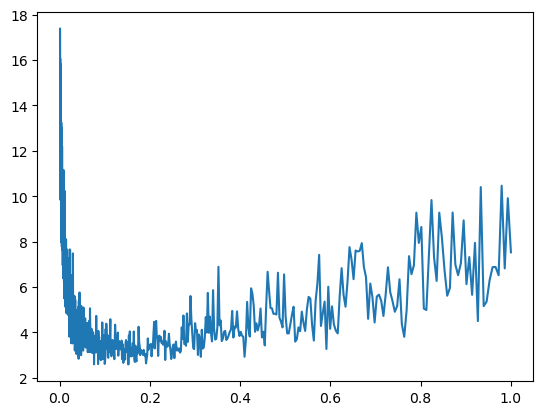

In [13]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

parameters = [C, W1, b1, W2, b2] # for a later part of the problem
for p in parameters:
    p.requires_grad = True

learning_rates = []
losses = []

# full gradient descent is slow
for i in range(1000):
    ix = torch.randint(0, X.shape[0], (32,))
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    for p in parameters:
        p.grad = None
    
    loss.backward()

    lr = lrs[i]
    for p in parameters:
        p.data -= lr * p.grad
    
    learning_rates.append(lr)
    losses.append(loss.item())

# print(loss.item())

plt.plot(learning_rates, losses)

In [14]:
# It seems like around 10 ^ (0.5 - 1.5) is the best learning rate

# use torch.randint to generate random indexes

# W1 = torch.randn((6, 100))
# b1 = torch.randn(100)
# W2 = torch.randn((100, 27))
# b2 = torch.randn(27)


# parameters = [C, W1, b1, W2, b2] # for a later part of the problem
# for p in parameters:
#     p.requires_grad = True


# full gradient descent is slow
for _ in range(10000):
    ix = torch.randint(0, X.shape[0], (32,))
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    for p in parameters:
        p.grad = None
    
    loss.backward()

    for p in parameters:
        p.data -= 0.005 * p.grad

print(loss.item())

emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

2.270599842071533


tensor(2.5078, grad_fn=<NllLossBackward0>)

In [15]:
def build_dataset(words):
    # first, initialize X and Y sets
    block_size = 3
    X, Y = [], []

    for w in words:
        # use the 3 previous characters to predict the next character (similar to trigram approach):
        context = [0] * block_size
        for ch in w + '.':
            idx = char_to_idx[ch]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx]
    

    X, Y = torch.tensor(X), torch.tensor(Y)

    return X, Y

def build_model():
    # initialize the parameters of the model
    C = torch.randn((27, 10))
    W1 = torch.randn((30, 300))
    b1 = torch.randn(300)
    W2 = torch.randn((300, 27))
    b2 = torch.randn(27)

    return [C, W1, b1, W2, b2]

def train_model(Xtr, Ytr, Xte, Yte, parameters, learning_rate = 0.1, epochs = 10000):
    C, W1, b1, W2, b2 = parameters

    for p in parameters:
        p.requires_grad = True

    for _ in range(epochs):
        # implement stochastc gradient descent to train the model
        ix = torch.randint(0, Xtr.shape[0], (32,))

        # embedding vector
        emb = C[Xtr[ix]]

        # first layer
        h = torch.tanh(emb.view(-1, 30) @ W1 + b1)

        # second layer
        logits = (h @ W2) + b2

        # cross entropy loss
        loss = F.cross_entropy(logits, Ytr[ix])

        # make sure gradients aren't adding on top of each other
        for p in parameters:
            p.grad = None
        
        # backwards pass
        loss.backward()

        # update parameters
        for p in parameters:
            p.data -= learning_rate * p.grad

    # find total loss based on Yte
    emb = C[Xte]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yte)
    return loss


In [16]:
# now, let's do a train test split
import random
random.seed(42)

all_names = words['name']
random.shuffle(all_names)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(all_names[:n1])
Xdev, Ydev = build_dataset(all_names[n1:n2])
Xte, Yte = build_dataset(all_names[n2:])
parameters = build_model()

In [32]:
train_model(Xtr, Ytr, Xdev, Ydev, parameters, learning_rate = 0.001, epochs = 10000)

tensor(2.2940, grad_fn=<NllLossBackward0>)

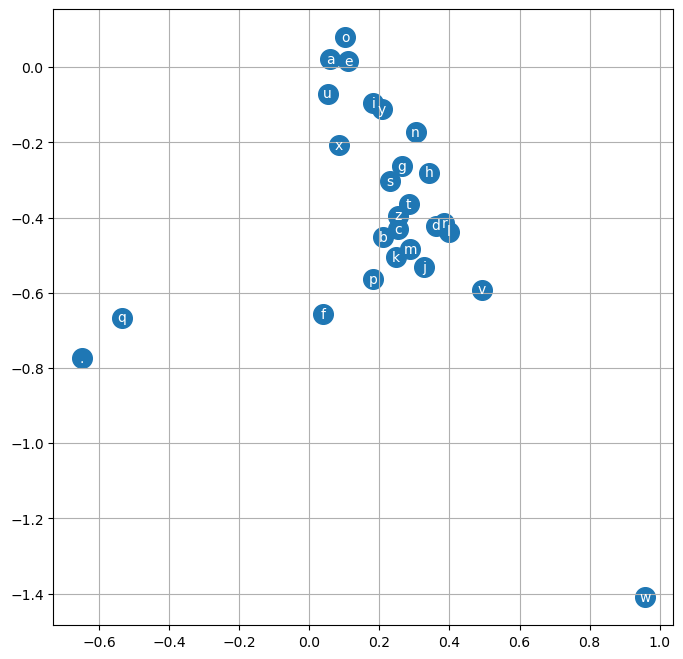

In [29]:
plt.figure(figsize = (8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s = 200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), idx_to_char[i], ha = "center", va = "center", color = "white")
plt.grid("Minor")

In [35]:
for _ in range(20):
    out = []
    context = [0] * 3
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = logits.softmax(dim = 1)
        ix = torch.multinomial(probs, num_samples = 1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(idx_to_char[i] for i in out))

solyrdi.
ely.
arra.
erdal.
rirerinon.
haretavelhwixfyas.
dureo.
jaemyac.
eymiet.
rryihe.
retdessae.
zwanse.
cbe.
eireem.
eliii.
praomakihenciin.
goca.
cesay.
lhe.
kan.
